## This is an example of running a historical simulation with the `strategy` library

In [1]:
%pylab inline
import pandas as pd
import strategy
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


## Read data for instantiating an Exposures object which contains tradeable instrument price and meta data

In [2]:
# these are not CME holidays but the pricing source used is excluding them since there is no settlements
# on these days, so define them as adhoc holidays to avoid trading on them since there is no price data
adhoc_holidays = [pd.Timestamp("1999-11-25", tz='UTC'),
                  pd.Timestamp("2001-05-28", tz='UTC'),
                  pd.Timestamp("2004-11-25", tz='UTC'),
                  pd.Timestamp("2007-05-28", tz='UTC'),
                  pd.Timestamp("2010-11-25", tz='UTC'),
                  pd.Timestamp("2012-05-28", tz='UTC'),]

In [3]:
CAPITAL=1000000
ROOT_GENERICS = ["ES", "TY"]
GENERICS = ["ES1", "TY1"]
START_DATE = pd.Timestamp('1999-01-01')
END_DATE = pd.Timestamp('2017-02-28')

instr_meta_data = strategy.strategy.Exposures.parse_meta('../tests/marketdata/instrument_meta.json')
instr_meta_data = instr_meta_data.loc[:, ROOT_GENERICS]
instr_meta_data

,ES,TY
exchange,CME,CME
generics,[ES1],[TY1]
instrument_type,future,future
multiplier,50,1000


In [4]:
prices, expiries = strategy.strategy.Exposures.parse_folder('../tests/marketdata/', 
                                                            instr_meta_data.loc["instrument_type"])

exposures = strategy.strategy.Exposures(prices, expiries, instr_meta_data)

/home/matthew/Projects/strategy/strategy/strategy.py:119: UserWarning: Expiry data without futures price data:{'2018TYH', '2018ESH', '2018ESM'}

  warnings.warn(warning)


In [5]:
print(prices["ES"].head())
print(prices["TY"].head())

                     settle
date       contract        
1997-09-09 1997ESU    934.0
           1997ESZ    944.0
1997-09-10 1997ESU    915.0
           1997ESZ    925.0
1997-09-11 1997ESU    908.0
                       settle
date       contract          
1982-05-03 1982TYM   71.28125
           1982TYU   71.50000
           1982TYZ   71.71875
           1983TYH   72.15625
           1983TYM   72.40625


In [6]:
expiries.head()

,contract,first_notice,last_trade
0,1982TYM,1982-05-28,1982-06-21
1,1982TYU,1982-08-31,1982-09-21
2,1982TYZ,1982-11-30,1982-12-20
3,1983TYH,1983-02-28,1983-03-22
4,1983TYM,1983-05-31,1983-06-21


In [7]:
exposures

Exposures:
----------
root_generic         ES      TY
exchange            CME     CME
instrument_type  future  future
multiplier           50    1000

Generic Futures: ('ES1', 'TY1')
Equities: ()

## Instantiate a Portfolio object which containts an Exposures object for managing instruments as well as rolling logic

In [8]:
# portfolio that rolls all futures contracts for a given contract on the third day before the First Notice day.
roll_offset = -3
all_monthly = False
port = strategy.portfolios.ExpiryPortfolio(roll_offset, all_monthly, exposures, START_DATE, END_DATE, CAPITAL,
                                           holidays=adhoc_holidays)

/home/matthew/Projects/strategy/strategy/strategy.py:552: UserWarning: Generic instrument ES on exchange CME missing price data for tradeable calendar dates:
DatetimeIndex(['2000-01-17', '2000-02-21', '2001-09-12', '2002-01-21',
               '2002-02-18', '2002-05-27', '2002-07-04', '2002-09-02',
               '2002-11-28', '2003-01-20', '2003-02-17', '2003-05-26',
               '2003-07-04', '2003-09-01', '2003-11-27', '2004-01-19',
               '2004-02-16', '2004-05-31', '2004-07-05', '2004-09-06',
               '2004-11-25', '2005-02-21', '2013-05-27', '2013-07-04',
               '2013-09-02', '2013-11-28', '2014-01-20', '2014-02-17',
               '2014-05-26', '2014-07-04', '2014-09-01', '2014-11-27',
               '2015-01-19', '2015-02-16', '2015-05-25', '2015-07-03',
               '2015-09-07', '2015-11-26', '2016-01-18', '2016-02-15',
               '2016-05-30', '2016-07-04', '2016-09-05', '2016-11-24',
               '2017-01-16', '2017-02-20'],
              dty

In [9]:
port

Portfolio Initial Capital: 1000000
Portfolio Exposures:
Exposures:
----------
root_generic         ES      TY
exchange            CME     CME
instrument_type  future  future
multiplier           50    1000

Generic Futures: ('ES1', 'TY1')
Equities: ()

Date Range:
----------
Start: 1999-01-01 00:00:00
End: 2017-02-28 00:00:00

## Inspect the continuous instrument returns associated with portfolio roll rules

In [10]:
rets = port.continuous_rets()
rets.head()

,ES1,TY1
1999-01-04,-0.003813,-0.001574
1999-01-05,0.009871,-0.002889
1999-01-06,0.021743,0.001844
1999-01-07,-0.002343,-0.002892
1999-01-08,0.008219,-0.005802


In [11]:
rets.isnull().sum()

ES1     47
TY1    127
dtype: int64

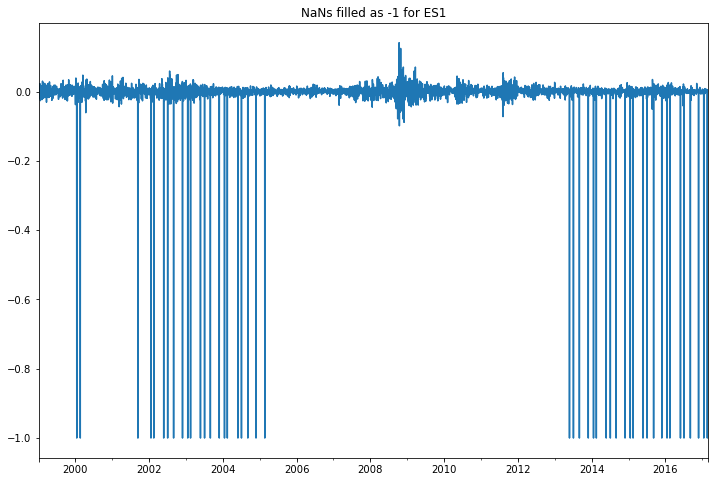

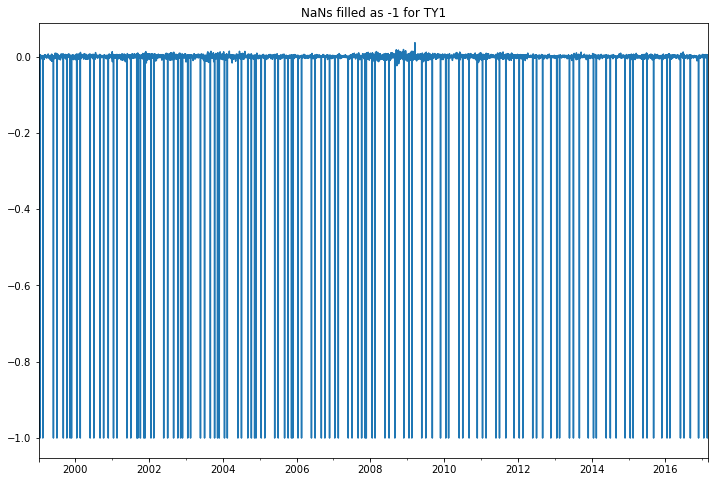

In [12]:
for ast in GENERICS:
    plt.figure()
    rets.fillna(value=-1)[ast].plot(title="NaNs filled as -1 for %s" % ast, figsize=(12, 8))

In [13]:
rets = rets.fillna(value=0)

## Inspect the days to expiry for the continuous returns

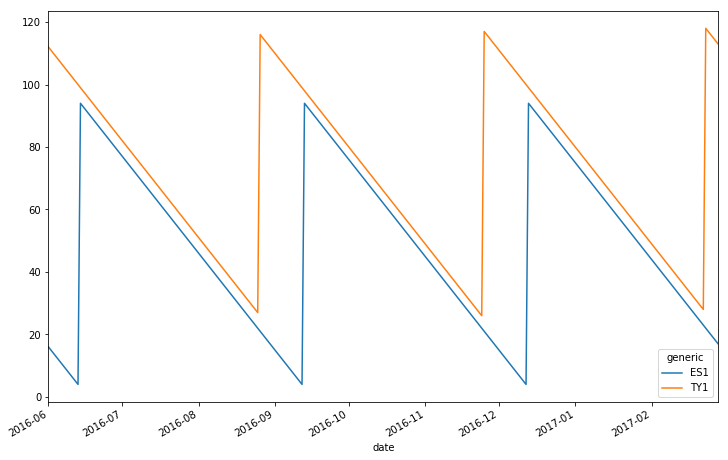

In [14]:
durations = port.generic_durations()
durs = []
for ast in durations:
    durs.append(durations[ast])
    
durs = pd.concat(durs, axis=1)
durs.loc["2016-06":].plot(figsize=(12,8))

## A simple trading signal that is long 1 unit of both ES1 and TY1. This will be scaled by the risk target as well as the capital of the Portfolio.

In [15]:
signal = pd.DataFrame(1, index=port.tradeable_dates(), columns=GENERICS)
signal.head()

,ES1,TY1
1999-01-04,1,1
1999-01-05,1,1
1999-01-06,1,1
1999-01-07,1,1
1999-01-08,1,1


## Run simulations for strategies using fungible instrument (e.g. investment not constrained to trade in discrete instrument sizes) and tradeable instruments with capital reinvested

In [16]:
fungible_sim_res = port.simulate(signal)

In [17]:
trdbl_sim_res = port.simulate(signal, tradeables=True)

## Analyze strategy performance

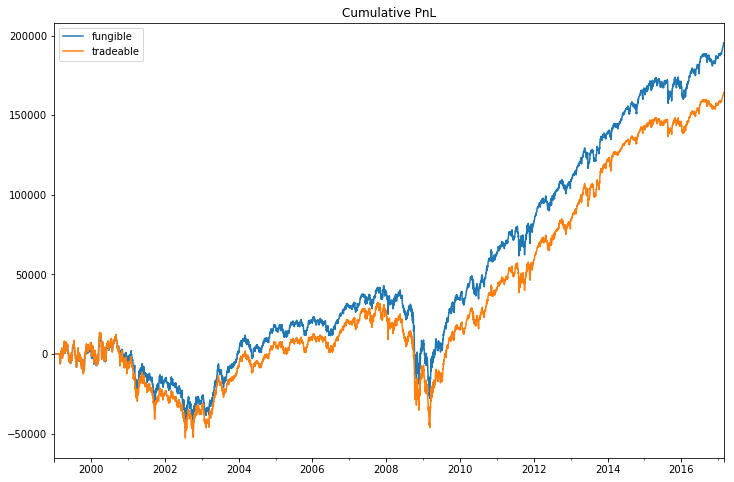

In [18]:
pnls = pd.concat([fungible_sim_res.pnl, trdbl_sim_res.pnl], keys=['fungible', 'tradeable'], axis=1)
pnls.cumsum().plot(figsize=(12, 8), title="Cumulative PnL")

## Cumulative PnL

In [19]:
pnls.cumsum().iloc[-1,:]

fungible     194769.363837
tradeable    163677.512273
Name: 2017-02-28 00:00:00, dtype: float64

## Analyze annualized risk

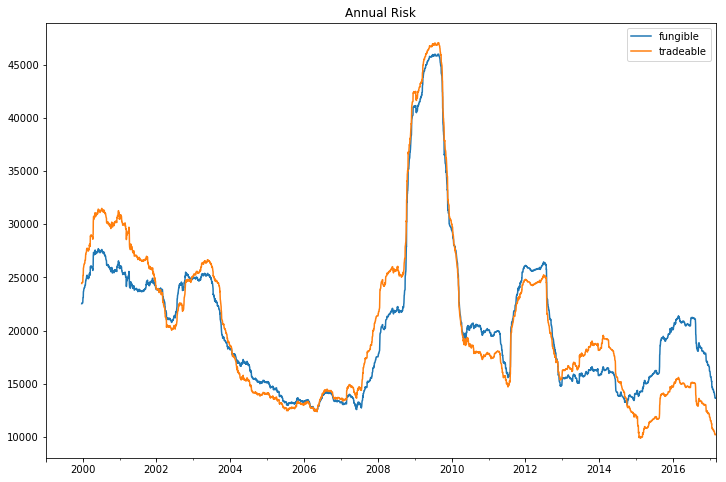

In [20]:
(pnls.rolling(window=252).std() * sqrt(252)).plot(figsize=(12, 8), title="Annual Risk")

## Full sample statistics with fungible contracts and constant capital

In [21]:
exposure_constant, _, pnls_constant = port.simulate(signal, tradeables=False, reinvest=False)

In [22]:
def stats(pnls, exps):
    ann_std = pd.np.sqrt(252) * pnls.std()
    ann_mean = 252 * pnls.mean()
    IR = ann_mean / ann_std

    rets_constant = pnls / exps.abs().sum(axis=1).shift(1)
    kelly = rets_constant.mean() / rets_constant.var()

    return pd.DataFrame(["{:,.2f}".format(ann_std), "{:,.2f}".format(ann_mean), IR, kelly,
                         "{:,.2f}".format(CAPITAL)],
                        index=["Ann Std", "Ann Mean", "IR", "kelly fraction", "capital"])

In [23]:
stats_fs = stats(pnls_constant, exposure_constant)
stats_fs.columns = [pnls_constant.index[0].strftime("%Y-%m-%d") + " - " + pnls_constant.index[-1].strftime("%Y-%m-%d")]
idx = round(len(pnls_constant)/2)
stats_hs = stats(pnls_constant.iloc[idx:], exposure_constant.iloc[idx:])
stats_hs.columns = [pnls_constant.index[idx].strftime("%Y-%m-%d") + " - " + pnls_constant.index[-1].strftime("%Y-%m-%d")]

pd.concat([stats_fs, stats_hs], axis=1)


,1999-01-04 - 2017-02-28,2008-02-01 - 2017-02-28
Ann Std,"21,083.90","21,871.23"
Ann Mean,"9,747.66","15,712.71"
IR,0.462327,0.718419
kelly fraction,5.19611,7.40877
capital,"1,000,000.00","1,000,000.00"


## Risk for constant capital

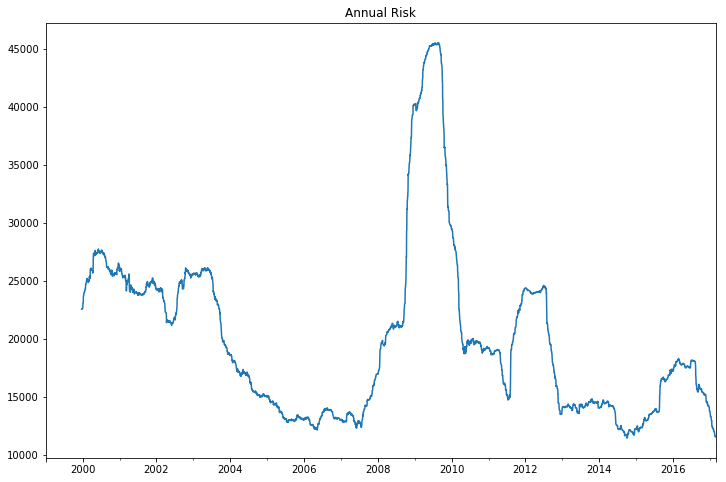

In [24]:
(pnls_constant.rolling(window=252).std() * sqrt(252)).plot(figsize=(12, 8), title="Annual Risk")